# Import Modules

In [6]:
%pip install tensorflow_datasets==4.9.3 -q

Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os

# Import Dataset

In [27]:
train_dir = "ML/data/Indonesian Food.v1i.folder/train"
val_dir = "ML/data/Indonesian Food.v1i.folder/valid"
test_dir = "ML/data/Indonesian Food.v1i.folder/test"

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 1905 files belonging to 18 classes.
Found 178 files belonging to 18 classes.
Found 89 files belonging to 18 classes.
Classes: ['01. Ayam Betutu', '02. Beberuk Terong', '03. Coto Makassar', '04. Gudeg', '05. Kerak Telor', '06. Mie Aceh', '07. Nasi Kuning', '08. Nasi Pecel', '09. Papeda', '10. Pempek', '11. Peuyeum', '12. Rawon', '13. Rendang', '14. Sate Madura', '15. Serabi', '16. Soto Banjar', '17. Soto Lamongan', '18. Tahu Sumedang']


# Preprocessing Steps

In [28]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

inputs = tf.keras.Input(shape=img_size + (3,))

# Data augmentation di dalam model supaya cuma berlaku waktu training
x = data_augmentation(inputs)

# ResNet50 tanpa pretrained weights (random init), include_top=False supaya bisa pakai dense sendiri
base_model = ResNet50(weights=None, include_top=False, input_tensor=x, pooling='avg')

# Dense layer output 18 kelas
outputs = layers.Dense(len(class_names), activation='softmax')(base_model.output)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ sequential[0][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 23,624,594 (90.12 MB)

 Trainable params: 23,571,474 (89.92 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [31]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3835 - loss: 1.8889 - val_accuracy: 0.0674 - val_loss: 9.8963
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4498 - loss: 1.7572 - val_accuracy: 0.0618 - val_loss: 21.4013
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5667 - loss: 1.3744 - val_accuracy: 0.0618 - val_loss: 14.0511
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6075 - loss: 1.1509 - val_accuracy: 0.0674 - val_loss: 18.4683
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6922 - loss: 0.9361 - val_accuracy: 0.1236 - val_loss: 14.5758
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6923 - loss: 0.9424 - val_accuracy: 0.1348 - val_loss: 8.3347
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7528 - loss: 0.7561 - val_accuracy: 0.3258 - val_loss: 3.8050
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7397 - loss: 0.7651 - val_accuracy: 0.2921 - val_

In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.grid(True)
    plt.show()

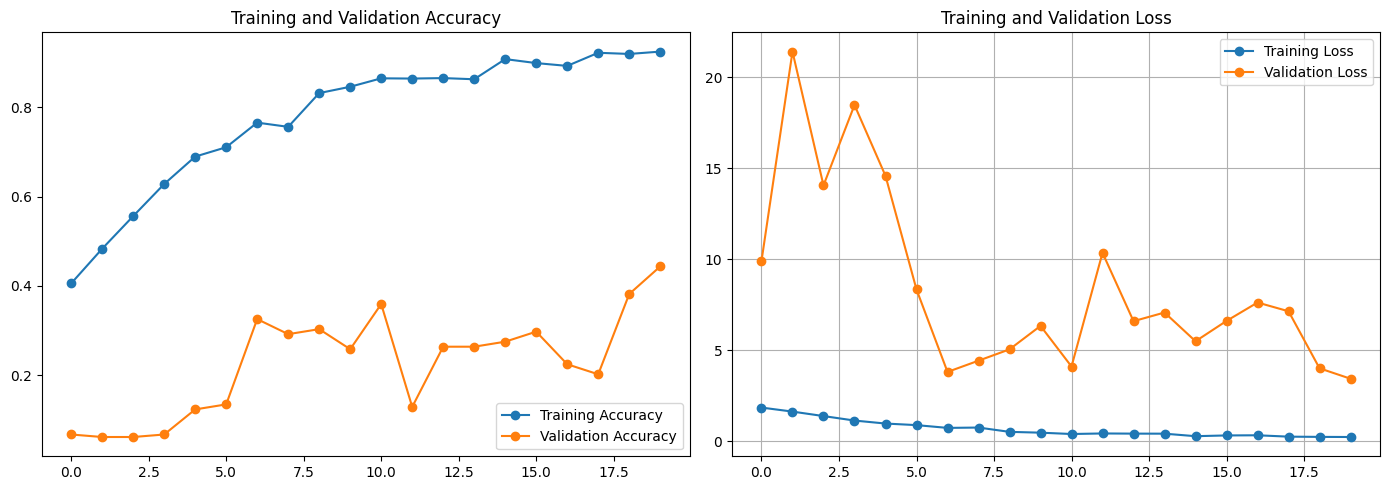

In [33]:
plot_history(history)  # for initial training

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


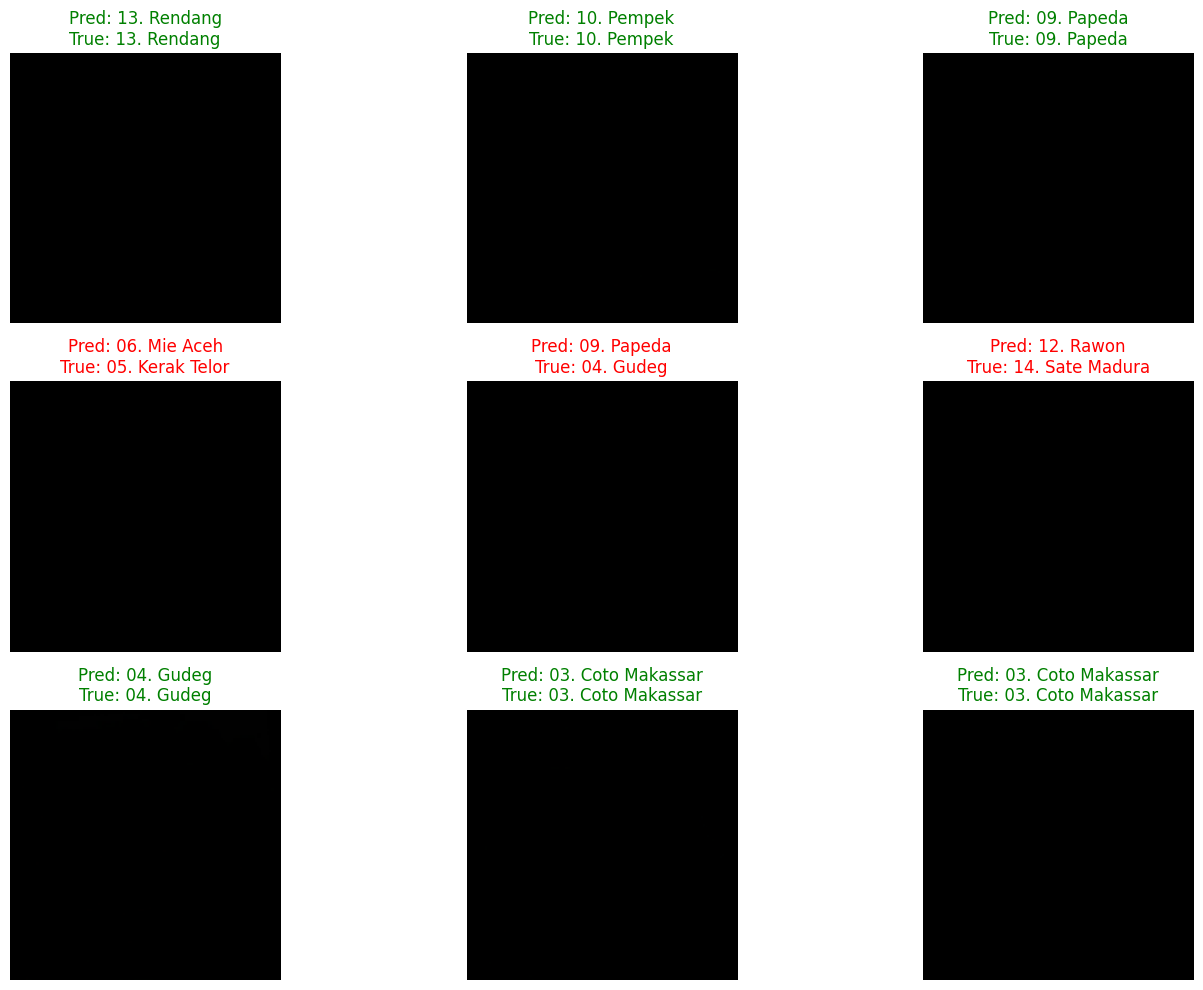

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Get a batch of images and labels
for images, labels in train_ds.take(1):  # take one batch
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(9, len(images))):  # plot first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        predicted_label = class_names[pred_labels[i]]
        color = "green" if predicted_label == true_label else "red"
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()